In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings

warnings.filterwarnings('ignore')

## Choose pgroup and run number

In [2]:
pgroup='p21185'
runnumber = 43
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
print (jsonfile)
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
if scan.parameters['scan_name'] != 'dummy':
    if scan.parameters['units'] == ['fs']:
        Timezero_mm = get_timezero_NBS(jsonfile)
        scanvar = scan.readbacks - mm2fs(Timezero_mm, 0)
    else: 
        scanvar = scan.readbacks
    print ('Scan contains {} step(s), scanvar goes from {:.2f} to {:.2f} {}'.format(len(scan), scanvar[0], scanvar[-1], scan.parameters['units'][0]))
else:
    print ('No motors moved')

run: 0043
/sf/alvra/data/p21185/raw/run0043-FeOX_RIXS_pre-edge_150fs_16uJ_001/meta/scan.json
Scan contains 20 step(s), scanvar goes from 7105.97 to 7117.95 eV


In [3]:
threshold_low = 5
threshold_high = 100

channels_list = []

reducedir='../Claudio/Reduced_RIXS/'
saveflag = False
#####################################################

import sfdata.sfdatafile
sfdata.sfdatafile.ju = None
scan = SFScanInfo(jsonfile)
    
spectra_on, spectra_off,_,_, ROIs, Energy_eV, meta = RIXS_PumpProbe_ROIs(scan, channels_list, threshold_low, threshold_high)
    
run_name = jsonfile.split('/')[-3]
if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_data_XES_timescans_ROIs(reducedir, run_name, spectra_on, spectra_off, ROIs, meta)    

Processing: run0043-FeOX_RIXS_pre-edge_150fs_16uJ_001
Step 20 of 20: Processing acq0020

--------------------------------------------------------------------------------

JF02T09V03:ROI_KaDW     2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaDW_bkg 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP     2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP_bkg 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW     2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW_bkg 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP     2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP_bkg 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2001 / 2001 -> 0% loss
complete channels: 9 / 9 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 990 pump and 990 unpump shots


## Plot ALL the ROIs

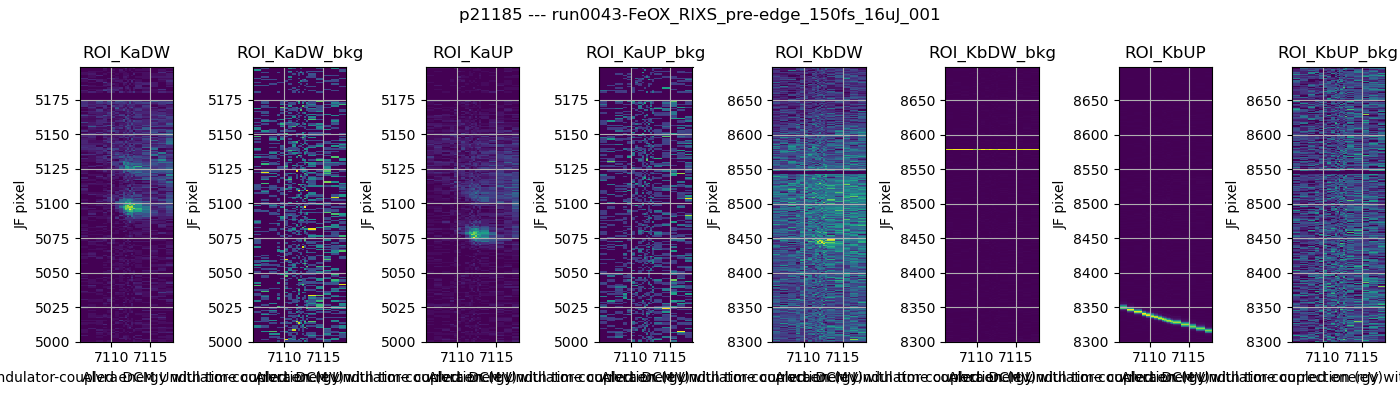

In [8]:
energy_calib = False

m = -5.430862659608205
b = 16537.553363439678

bin_ = 1

vmin = None
vmax = None

################################################

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(14,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    matrix_off = []
    for index_step in range(len(spectra_off)):
        matrix_off.append(spectra_off[index_step][key])#.split(':')[-1]])
        
    yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)
    
    ylabel = 'JF pixel'
    if energy_calib:
        y_axis_rebin = (y_axis_rebin-b)/m
        ylabel = 'Emission energy (eV)'
            
    plt.sca(ax)
    plt.title(key.split(':')[-1])
    plt.pcolormesh(Energy_eV, y_axis_rebin, np.transpose(np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
    #plt.plot(Energy_eV, np.transpose(np.asarray(matrix_off_rebin)).sum(axis=0))
    #plt.colorbar()
    plt.ylabel(ylabel)
    #plt.ylim(3120, 3180)
    plt.grid()
    plt.xlabel('{} ({})'.format(scan.parameters['name'][0],scan.parameters['units'][0]))
plt.tight_layout()

## Plot only ONE ROI (defined by the key)

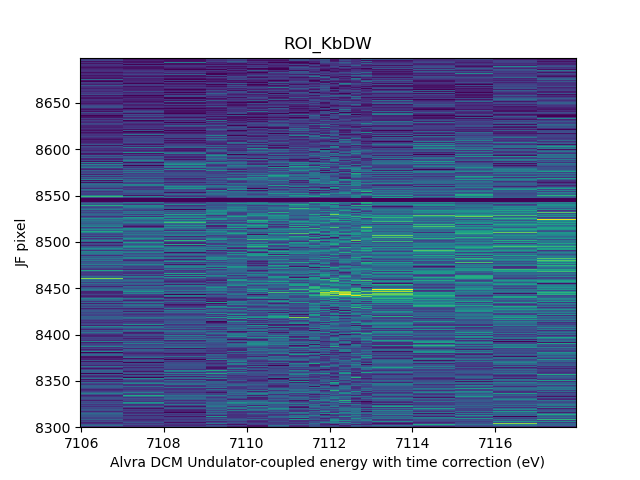

In [14]:
key = 'JF02T09V03:ROI_KbDW'

bin_ = 1

vmin = None
vmax = None

#######################################
matrix_off = []
for index_step in range(len(spectra_off)):
    matrix_off.append(spectra_off[index_step][key])#.split(':')[-1]])
plt.figure()
plt.title(key.split(':')[-1])
yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)

plt.pcolormesh(Energy_eV, y_axis_rebin, np.transpose(np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
plt.xlabel('{} ({})'.format(scan.parameters['name'][0],scan.parameters['units'][0]))
plt.ylabel('JF pixel')
#plt.axhline(y = 5098, color = 'r', linestyle = 'dashed')
plt.show()

## Plot pump probe for 1 ROI

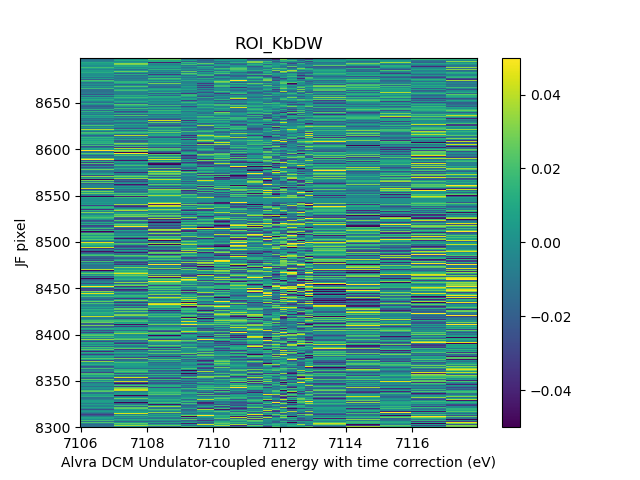

In [17]:
key = 'JF02T09V03:ROI_KbDW'

vmin = -0.05
vmax = 0.05

#######################################
matrix_on = []
matrix_off = []
for index_step in range(len(spectra_off)):
    matrix_off.append(spectra_off[index_step][key])#.split(':')[-1]])
    matrix_on.append(spectra_on[index_step][key])#.split(':')[-1]])
plt.figure()
plt.title(key.split(':')[-1])
yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)
y_axis_rebin, matrix_on_rebin = plot_tool_static_2D(matrix_on, 0, yaxis, bin_)

plt.pcolormesh(Energy_eV, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin)-np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
plt.xlabel('{} ({})'.format(scan.parameters['name'][0],scan.parameters['units'][0]))
plt.ylabel('JF pixel')
plt.colorbar()
#plt.axhline(y = 5098, color = 'r', linestyle = 'dashed')
plt.show()

## Load runs in a loop

In [3]:
pgroup='p21185'
runlist = np.arange(43, 98, 1)

print ('{} runs: {}'.format(len(runlist),runlist))

#############################################################
from itertools import chain
jsonlist = []
for run in runlist:
    file = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))
    jsonlist.append(file)
jsonlist = itertools.chain.from_iterable(jsonlist)
jsonlist = sorted(jsonlist, key = os.path.getmtime)
#jsonlist

55 runs: [43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90
 91 92 93 94 95 96 97]


In [6]:
threshold_low = 5
threshold_high = 100

channels_list = []

reducedir='../Claudio/Reduced_RIXS/'
saveflag = True
#####################################################
from sfdata import SFScanInfo
import sfdata.sfdatafile
sfdata.sfdatafile.ju = None

for jsonfile in jsonlist:
    scan = SFScanInfo(jsonfile)

    spectra_on, spectra_off,_,_, ROIs, Energy_eV, meta = RIXS_PumpProbe_ROIs(scan, channels_list, threshold_low, threshold_high)

    run_name = jsonfile.split('/')[-3]
    if saveflag:
        os.makedirs(reducedir+run_name, exist_ok=True)
        save_data_RIXS_ROIs(reducedir, run_name, spectra_on, spectra_off, ROIs, Energy_eV, meta)    

Processing: run0097-FeOX_RIXS_pre-edge_150fs_16uJ_055
Step 20 of 20: Processing acq0020

--------------------------------------------------------------------------------

JF02T09V03:ROI_KaDW     2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaDW_bkg 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP     2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP_bkg 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW     2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW_bkg 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP     2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP_bkg 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2001 / 2001 -> 0% loss
complete channels: 9 / 9 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 990 pump and 990 unpump shots


In [ ]:
np.shape(matrix_on['JF02T09V03:ROI_KbDW'])

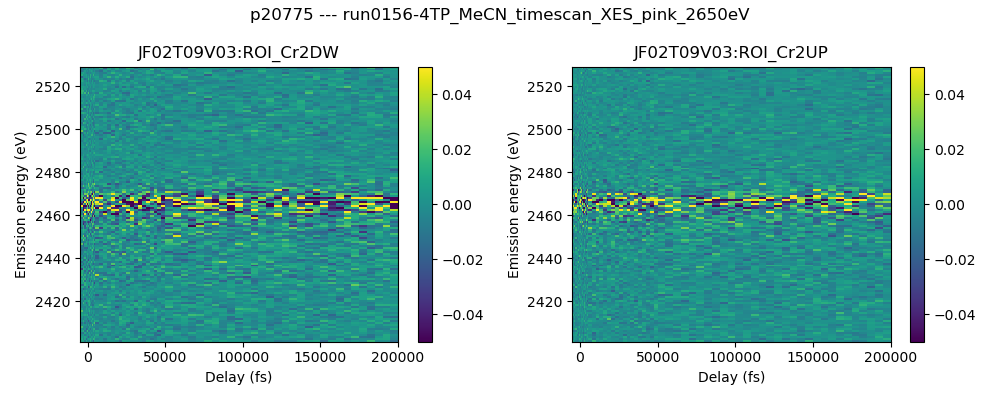

In [68]:
energy_calib = True

m = -5.430862659608205
b = 16537.553363439678

bin_ = 5

vmin = -0.05
vmax = 0.05

################################################

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(10,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    matrix_on = []
    matrix_off = []
    for index_step in range(len(spectra_on)):
        matrix_on.append(spectra_on[index_step][key])#.split(':')[-1]])
        matrix_off.append(spectra_off[index_step][key])#.split(':')[-1]])
        
    yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    y_axis_rebin, matrix_on_rebin, matrix_off_rebin = plot_tool_2D(matrix_on, matrix_off, 0, yaxis, bin_)
    
    ylabel = 'JF pixel'
    if energy_calib:
        y_axis_rebin = (y_axis_rebin-b)/m
        ylabel = 'Emission energy (eV)'
    
    plt.sca(ax)
    plt.title(key)
    plt.pcolormesh(Delay_fs, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin) - np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.ylabel(ylabel)
    #plt.ylim(3120, 3180)
    plt.xlabel('Delay ({})'.format(scan.parameters['units'][0]))
plt.tight_layout()

In [53]:
print(matrix_on.shape)

AttributeError: 'list' object has no attribute 'shape'

In [5]:
def rebin2D(arr, axis, bin_):
    arr = np.array(arr)
    arr_new=[]
    if axis == 1:
        arr=arr.T
    for index in range(len(arr)):
        cut=arr[index]
        new=bin_sum(cut,bin_)
        arr_new.append(new)
    arr_new=np.array(arr_new)
    if axis == 1:
        arr_new=arr_new.T
    return arr_new

In [6]:
def plot_tool_2D(matrix_ON, matrix_OFF, axis, x_axis, bin_):
    
    matrix_on_rebin  = rebin2D(matrix_ON, axis, bin_)
    matrix_off_rebin = rebin2D(matrix_OFF, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_on_rebin, matrix_off_rebin#, low_err, high_err

In [7]:
def plot_tool_static_2D(matrix, axis, x_axis, bin_):
    
    matrix_rebin  = rebin2D(matrix, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_rebin